### Library Import

In [96]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [97]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

### Data Load

In [98]:
# 파일 호출
data_path: str = "/data/ephemeral/home/BTC/data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [99]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


100%|██████████| 107/107 [00:02<00:00, 38.09it/s]


### EDA (Explanatory Data Analysis)

In [100]:
eda_df = df.loc[df["_type"] == "train"]
# 각 열에서 누락된 값의 수를 계산
missing_values = eda_df.isnull().sum()

# 누락된 값의 백분율 계산
missing_percentage = (missing_values / len(eda_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)
sorted_missing_percentage

hourly_market-data_open-interest_all_exchange_open_interest                       100.000000
hourly_market-data_open-interest_okex_open_interest                               100.000000
hourly_market-data_open-interest_bitmex_open_interest                             100.000000
hourly_market-data_liquidations_ftx_all_symbol_long_liquidations                  100.000000
hourly_market-data_liquidations_ftx_all_symbol_short_liquidations                 100.000000
hourly_market-data_liquidations_ftx_all_symbol_long_liquidations_usd              100.000000
hourly_market-data_liquidations_ftx_all_symbol_short_liquidations_usd             100.000000
hourly_market-data_liquidations_ftx_btc_usd_short_liquidations                    100.000000
hourly_market-data_liquidations_ftx_btc_usd_long_liquidations                     100.000000
hourly_market-data_open-interest_binance_open_interest                            100.000000
hourly_market-data_taker-buy-sell-stats_okex_taker_buy_volume         

In [101]:
# column 추출
# 1. ID, target, blockreward_usd, hashrate(difficulty), supply_new
# hashrate = 직접적이고 즉각적인 영향보다는 장기적인 영향
#  채굴 보상(blockreward_usd)이 낮아지면 공급이 낮아지고 가격이 올라감
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target", 
    "hourly_network-data_blockreward_blockreward_usd": "blockreward_usd",
    "hourly_network-data_hashrate_hashrate": "hashrate",
    "hourly_network-data_difficulty_difficulty": "difficulty",
    "hourly_network-data_supply_supply_total": "supply_total",
}

# 추출후 단순화를 위해 rename
eda_df = eda_df[cols_dict.keys()].rename(cols_dict, axis=1)
eda_df.describe()

,target,blockreward_usd,hashrate,difficulty,supply_total
count,8760.000000,8.760000e+03,8.760000e+03,8.741000e+03,8.760000e+03
mean,1.518379,1.189293e+06,3.782604e+11,5.194337e+13,1.941791e+07
std,0.776190,6.015863e+05,1.693080e+11,9.201383e+12,9.689445e+04
min,0.000000,0.000000e+00,0.000000e+00,3.409357e+13,1.924871e+07
25%,1.000000,7.671066e+05,2.568262e+11,4.684340e+13,1.933482e+07
50%,2.000000,1.099983e+06,3.625397e+11,5.232831e+13,1.941775e+07
75%,2.000000,1.489747e+06,4.787106e+11,5.711987e+13,1.950111e+07
max,3.000000,6.006830e+06,1.192349e+12,7.200615e+13,1.958613e+07


In [102]:
agg_df1 = eda_df.groupby('target')['blockreward_usd'].describe()
agg_df2 = eda_df.groupby('target')['hashrate'].describe()
agg_df3 = eda_df.groupby('target')['difficulty'].describe()
agg_df4 = eda_df.groupby('target')['supply_total'].describe()

print(agg_df1)
print(agg_df2)

         count          mean            std  min            25%           50%  \
target                                                                          
0.0      740.0  1.216460e+06  632445.905219  0.0  782631.978151  1.116853e+06   
1.0     3544.0  1.186873e+06  609060.676420  0.0  754810.970293  1.099768e+06   
2.0     3671.0  1.182565e+06  585057.691993  0.0  767941.964382  1.092368e+06   
3.0      805.0  1.205656e+06  613781.869777  0.0  783401.206043  1.116078e+06   

                 75%           max  
target                              
0.0     1.549242e+06  4.403477e+06  
1.0     1.482680e+06  6.006830e+06  
2.0     1.487655e+06  4.716728e+06  
3.0     1.523408e+06  4.167049e+06  
         count          mean           std  min           25%           50%  \
target                                                                        
0.0      740.0  3.725723e+11  1.731160e+11  0.0  2.498260e+11  3.587773e+11   
1.0     3544.0  3.791698e+11  1.715425e+11  0.0  2.568

In [103]:
print(agg_df3)
print(agg_df4)

         count          mean           std           min           25%  \
target                                                                   
0.0      738.0  5.183518e+13  8.658137e+12  3.409357e+13  4.684340e+13   
1.0     3535.0  5.196251e+13  9.194614e+12  3.409357e+13  4.684340e+13   
2.0     3665.0  5.202969e+13  9.357504e+12  3.409357e+13  4.684340e+13   
3.0      803.0  5.156461e+13  9.001075e+12  3.409357e+13  4.355172e+13   

                 50%           75%           max  
target                                            
0.0     5.123434e+13  5.562144e+13  7.200615e+13  
1.0     5.232831e+13  5.711987e+13  7.200615e+13  
2.0     5.232831e+13  5.732151e+13  7.200615e+13  
3.0     5.064621e+13  5.562144e+13  7.200615e+13  
         count          mean           std           min           25%  \
target                                                                   
0.0      740.0  1.941428e+07  90664.904107  1.925226e+07  1.933292e+07   
1.0     3544.0  1.941838e+0

In [104]:
# 타겟 값 별로 변수의 평균 파익
bar_df = eda_df.groupby("target").agg({
    "blockreward_usd" : "var",
    "hashrate" : "var",
    "difficulty" : "var",
    "supply_total" : "var",
}).reset_index()
bar_df

# 읭 차이가 없네 ..

,target,blockreward_usd,hashrate,difficulty,supply_total
0,0.0,3.999878e+11,2.996916e+22,7.496333e+25,8.220125e+09
1,1.0,3.709549e+11,2.942683e+22,8.454093e+25,9.441603e+09
2,2.0,3.422925e+11,2.733410e+22,8.756289e+25,9.690936e+09
3,3.0,3.767282e+11,3.023723e+22,8.101935e+25,8.807662e+09


In [105]:
# 보다 관계를 명확히 파악하기 위해 barplot을 이용한 시각화 코드 작성
fig: go.Figure = make_subplots(
    rows=2,
    cols=2,
    shared_xaxes=True,
    subplot_titles=(
    "blockreward_usd",
    "hashrate",
    "difficulty",
    "supply_total",
    ),
)
_target_disrtibution = eda_df["target"].value_counts() / len(eda_df)
fig.add_trace(
    go.Bar(
        x=_target_disrtibution.index, 
        y=_target_disrtibution,
    ), row=1, col=1
)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["blockreward_usd"]), row=1, col=1)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["hashrate"]), row=1, col=2)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["difficulty"]), row=2, col=1)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["supply_total"]), row=2, col=2)
fig.update_layout(title_text="Target statistics", showlegend=False)
fig.update_xaxes(title_text="Target", row=3)
fig.show()

- blockreward_usd와 hashrate의 분산이 target 값이 [1,2]일 때 감소하고, [0,3]일 때 증가함
- difficulty와 supply_total의 분산이 target 값이 [0,3]일 때 감소하고, [1,2]일 때 증가

- 두 변수의 분산 간 비슷한 양상

**가설**
- blockreward_usd와 hashrate의 분산 변화: [1,2]일 경우 분산 감소 -> 시장의 동향이 더 안정적
- difficulty와 supply_total의 분산 변화: [0,3]일 경우 분산 감소 -> 시장의 동향이 더 안정적

**근데 차트상 저렇게 미묘하게 나오면 쓸 수 있나요?..**

## blockreward_usd와 hashrate 간 상관관계

채굴 보상과 hashrate 상관관계: 0.9201558537183445


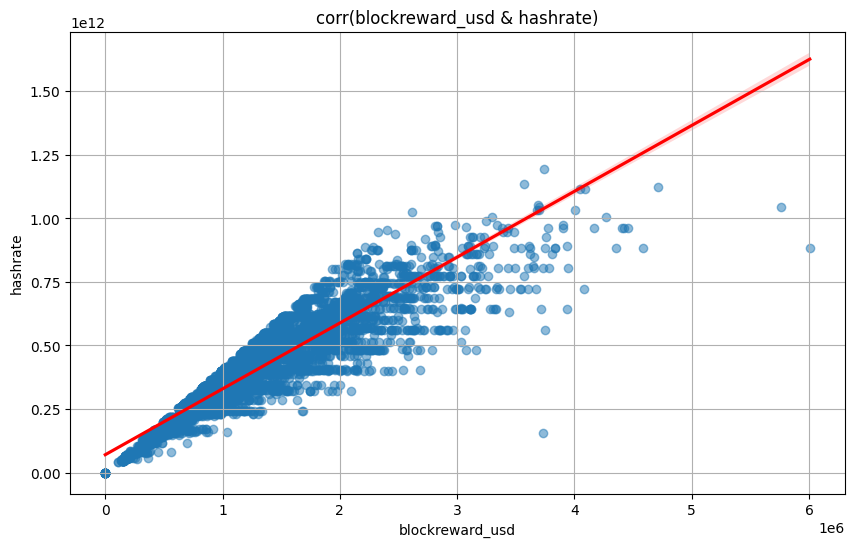

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

#blockreward_usd & hashrate 상관계수 계산
correlation = eda_df['blockreward_usd'].corr(eda_df['hashrate'])
print(f"채굴 보상과 hashrate 상관관계: {correlation}")

# 산점도와 회귀선 그리기
plt.figure(figsize=(10, 6))
sns.regplot(x='blockreward_usd', y='hashrate', data=eda_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('corr(blockreward_usd & hashrate)')
plt.xlabel('blockreward_usd')
plt.ylabel('hashrate')
plt.grid(True)
plt.show()

##  difficulty와 supply_total 간 상관관계

채굴 보상과 hashrate 상관관계: 0.9742219056805032


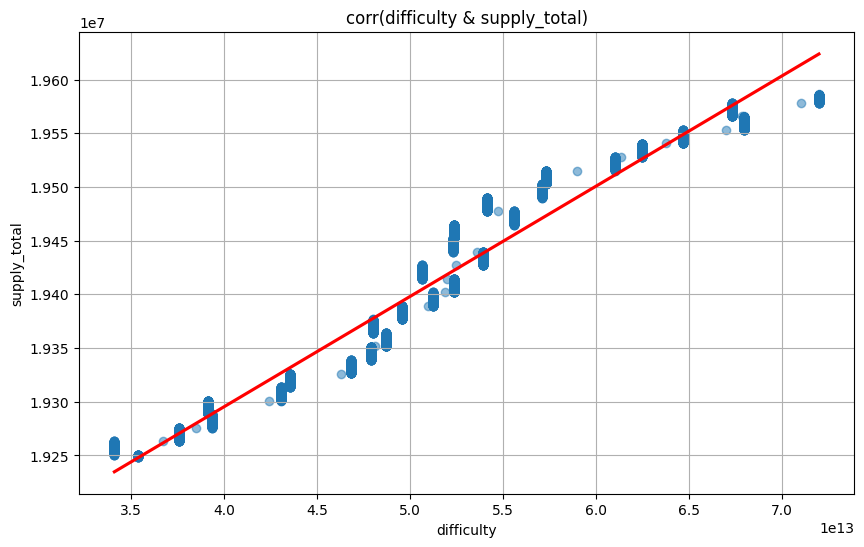

In [122]:
# difficulty와 supply_total 상관계수 계산
correlation = eda_df['difficulty'].corr(eda_df['supply_total'])
print(f"채굴 보상과 hashrate 상관관계: {correlation}")

# 산점도와 회귀선 그리기
plt.figure(figsize=(10, 6))
sns.regplot(x='difficulty', y='supply_total', data=eda_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('corr(difficulty & supply_total)')
plt.xlabel('difficulty')
plt.ylabel('supply_total')
plt.grid(True)
plt.show()

In [107]:
# column 추출
# 2. ID, target, fees_block_mean, difficulty, block_count, close, volume
# difficulty 높 - fee 높 - volume 낮 - 유동성 낮 - 가격급락 낮...
# 가격 변동 심할 때, 거래수 제한 - block_count 변화 살펴보기
# volume이 감소할수록 difficulty 증가할 것 (네트워크에서 트랜잭션이 적을 때, 블록 생성이 덜 이루어져서 상대적으로 난이도가 높아질 수 있다)
# difficulty가 증가할 수록 fees_transaction_mean_usd도 증가할 것(난이도 높을수록 블록 생성 과정 복잡, 채굴자들이 더 많은 보상)

cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target", 
    "hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume": "volume",
    "hourly_network-data_difficulty_difficulty": "difficulty",
    "hourly_network-data_fees-transaction_fees_transaction_mean_usd": "fees_transaction_mean_usd",
    "hourly_network-data_block-count_block_count": "block_count",

}
5
# 추출후 단순화를 위해 rename
eda_df = eda_df[list(cols_dict.keys())].rename(cols_dict, axis=1)

agg_df1 = eda_df.groupby('target')['volume'].describe()
agg_df2 = eda_df.groupby('target')['difficulty'].describe()
agg_df3 = eda_df.groupby('target')['fees_transaction_mean_usd'].describe()
agg_df4 = eda_df.groupby('target')['block_count'].describe()

#print(agg_df1) #mean
print(agg_df2) #
#print(agg_df3) #mean
print(agg_df4) # 별 차이없음 ㅠㅠ
# 거래가 적거나 블록당 보상이 적은 경우일수록 수수료가 낮아질 수 있음

In [108]:
# 타겟 값 별로 변수의 평균 파익
bar_df = eda_df.groupby("target").agg({
    "volume" : "mean",
    "difficulty" : "mean",
    "fees_transaction_mean_usd": "mean",
    "block_count" : "mean",
}).reset_index()
bar_df

In [109]:
# 보다 관계를 명확히 파악하기 위해 barplot을 이용한 시각화 코드 작성
fig: go.Figure = make_subplots(
    rows=2,
    cols=2,
    shared_xaxes=True,
    subplot_titles=(
    "target distribution",
    "volume",
    "difficulty",
    "fees_transaction_mean_usd",
    #"block_count",
    ),
)
_target_disrtibution = eda_df["target"].value_counts() / len(eda_df)
fig.add_trace(
    go.Bar(
        x=_target_disrtibution.index, 
        y=_target_disrtibution,
    ), row=1, col=1
)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["volume"]), row=1, col=2)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["difficulty"]), row=2, col=1)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["fees_transaction_mean_usd"]), row=2, col=2)
#fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["block_count"]), row=3, col=1)
fig.update_layout(title_text="Target statistics", showlegend=False)
fig.update_xaxes(title_text="Target", row=3)
fig.show()

In [110]:
# Bar plot 생성
mean_fees = eda_df.groupby('target')['fees_transaction_mean_usd'].mean().reset_index()

fig = px.bar(
    mean_fees, 
    x='target', 
    y='fees_transaction_mean_usd', 
    title='Mean Fees Transaction (USD) by Target',
    labels={'fees_transaction_mean_usd': 'Mean Fees Transaction (USD)', 'target': 'Target'}
)

fig.show()


In [111]:
# 각 target 그룹에 따른 fees_block_mean의 박스 플롯
fig = make_subplots(rows=1, cols=1)

for target_value in eda_df['target'].unique():
    subset = eda_df[eda_df['target'] == target_value]
    fig.add_trace(
        go.Box(
            y=subset['fees_transaction_mean_usd'], 
            name=f'Target {target_value}',
            boxmean='sd'  # 박스 평균과 표준편차
        )
    )

fig.update_layout(
    title_text="Box Plot of Fees Block Mean by Target",
    yaxis_title="Fees Block Mean"
)

fig.show()


**이상치 제거 필요**

In [112]:
fig = make_subplots(rows=1, cols=1)

for target_value in eda_df['target'].unique():
    subset = eda_df[eda_df['target'] == target_value]
    fig.add_trace(
        go.Histogram(
            x=subset['fees_block_mean'], 
            name=f'Target {target_value}',
            opacity=0.75
        )
    )

fig.update_layout(
    title_text="Histogram of Fees Block Mean by Target",
    xaxis_title="Fees Block Mean",
    yaxis_title="Count",
    barmode='overlay'  # 히스토그램을 겹치도록 설정
)

fig.show()


[0,3] [1,2] 간 차이 명확 하다고 생각했는데 COUNT라 그런듯 ㅠ

In [113]:
# 필요한 컬럼만 추출하여 상관계수 계산
correlation_matrix = eda_df[['target', 'fees_transaction_mean_usd', 'volume', 'difficulty']].corr()
print(correlation_matrix)

# difficulty가 증가할 수록 fees_transaction_mean_usd도 증가할 것(난이도 높을수록 블록 생성 과정 복잡, 채굴자들이 더 많은 보상)
# volume이 증가할수록 difficulty 감소할 것 (네트워크에서 트랜잭션이 많을 때, 블록 생성이 더 자주 이루어져서 상대적으로 난이도가 낮아질 수 있다)

In [114]:
fig = go.Figure()

# Volume Line
fig.add_trace(go.Scatter(x=eda_df.index, y=eda_df['volume'], mode='lines', name='Volume'))

# Difficulty Line
fig.add_trace(go.Scatter(x=eda_df.index, y=eda_df['difficulty'], mode='lines', name='Difficulty', yaxis='y2'))

# Fees Transaction Mean USD Line
fig.add_trace(go.Scatter(x=eda_df.index, y=eda_df['fees_transaction_mean_usd'], mode='lines', name='Fees Transaction Mean USD', yaxis='y3'))

# Layout
fig.update_layout(
    title="Volume, Difficulty, and Fees Transaction Mean over Time",
    xaxis_title="Time",
    yaxis=dict(title="Volume"),
    yaxis2=dict(title="Difficulty", overlaying='y', side='right'),
    yaxis3=dict(title="Fees Transaction Mean USD", overlaying='y', side='right', anchor='free', position=0.85),
)
fig.show()


** 가설 **
- target과 volume
- volume이 감소할수록 difficulty 증가할 것 (네트워크에서 트랜잭션이 많을 때, 블록 생성이 더 자주 이루어져서 상대적으로 난이도가 낮아질 수 있다)
- difficulty가 증가할 수록 fees_transaction_mean_usd도 증가할 것(난이도 높을수록 블록 생성 과정 복잡, 채굴자들이 더 많은 보상) -> 이건 확인되지 않았다

In [115]:
# 3. ID, target, open_interest, addresses_count_active, addresses_count_sender, addresses_count_receiver
# difficulty 높 - fee 높 - volume 낮 - 유동성 낮 - 가격급락 낮...
# 가격 변동 심할 때, 거래수 제한 - block_count 변화 살펴보기
# volume이 감소할수록 difficulty 증가할 것 (네트워크에서 트랜잭션이 적을 때, 블록 생성이 덜 이루어져서 상대적으로 난이도가 높아질 수 있다)
# difficulty가 증가할 수록 fees_transaction_mean_usd도 증가할 것(난이도 높을수록 블록 생성 과정 복잡, 채굴자들이 더 많은 보상)

cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target", 
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
    "hourly_network-data_addresses-count_addresses_count_active": "addresses_count_active", #sender + receiver
    "hourly_network-data_addresses-count_addresses_count_sender": "addresses_count_sender",
    "hourly_network-data_addresses-count_addresses_count_receiver": "addresses_count_receiver",

}

# 추출후 단순화를 위해 rename
eda_df = eda_df[list(cols_dict.keys())].rename(cols_dict, axis=1)

agg_df1 = eda_df.groupby('target')['open_interest'].describe()
agg_df2 = eda_df.groupby('target')['addresses_count_active'].describe()
agg_df3 = eda_df.groupby('target')['addresses_count_sender'].describe()
agg_df4 = eda_df.groupby('target')['addresses_count_receiver'].describe()

#print(agg_df1)
#print(agg_df2)
print(agg_df3) #mean
print(agg_df4) # 별 차이없음 ㅠㅠ
# 거래가 적거나 블록당 보상이 적은 경우일수록 수수료가 낮아질 수 있음

In [116]:
# 타겟 값 별로 변수의 평균 파익
bar_df = eda_df.groupby("target").agg({
    "open_interest" : "mean",
    "addresses_count_active" : "mean",
    "addresses_count_sender": "mean",
    "addresses_count_receiver" : "mean",
}).reset_index()
bar_df

In [117]:
# 보다 관계를 명확히 파악하기 위해 barplot을 이용한 시각화 코드 작성
fig: go.Figure = make_subplots(
    rows=3,
    cols=2,
    shared_xaxes=True,
    subplot_titles=(
    "target distribution",
    "",
    "open_interest",
    "addresses_count_active",
    "addresses_count_sender",
    "addresses_count_receiver",
    ),
)
_target_disrtibution = eda_df["target"].value_counts() / len(eda_df)
fig.add_trace(
    go.Bar(
        x=_target_disrtibution.index, 
        y=_target_disrtibution,
    ), row=1, col=1
)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["open_interest"]), row=2, col=1)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["addresses_count_active"]), row=2, col=2)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["addresses_count_sender"]), row=3, col=1)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["addresses_count_receiver"]), row=3, col=2)
fig.update_layout(title_text="Target statistics", showlegend=False)
fig.update_xaxes(title_text="Target", row=3)
fig.show()

In [118]:
# liquidation, volume 으로 차이를 새로 생성하여 target 변수와의 관계 확인
eda_df = eda_df.assign(
    receiver_sender_diff=eda_df['addresses_count_receiver'] - eda_df['addresses_count_sender'],
)
bar_df = eda_df.groupby("target").agg({"receiver_sender_diff" : "mean"}).reset_index()
bar_df # target 별로 liquidation diff, volume diff 가 각각 평균적으로 양의 관계, 음의 관계를 갖고 있음을 확인

In [119]:
fig: go.Figure = make_subplots(
    rows=1,
    cols=1,
    shared_xaxes=True,
    subplot_titles=(
        'receiver_sender_diff'
    ),
)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df['receiver_sender_diff']), row=1, col=1)
fig.update_xaxes(title_text="Target")
fig.update_layout(title_text="Target statistics", showlegend=False)
fig.show()